# Lecture 1

Settings that make the plots look pretty on my Mac:

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


You will need 

* [corner](https://github.com/dfm/corner.py).  Makes "corner" plots of distributions from samples.
* [pystan](https://pystan.readthedocs.io/en/latest/).  `pip install pystan` has always worked well for me.  (If you need a good Python distribution, I recommend [anaconda](https://www.continuum.io), which comes with a complete `numpy`, `scipy`, `iPython`, etc stack.)
* [seaborn](https://seaborn.pydata.org).  `pip install seaborn`.  Seaborn is a plotting library.

In [2]:
import corner
import pystan
import seaborn as sns

These are my favourite plotting styles:

In [3]:
sns.set_context('talk') #sns.set_context('notebook') is probably better on your monitor
sns.set_palette('colorblind')
sns.set_style('ticks')

## Preliminaries (Notes)

* $p(d, \theta) = p\left( d \mid \theta \right) p\left( \theta \right) = p\left( \theta \mid d \right) p\left( d \right)$ is the fundamental quantity.  A "just so" story about how you obtained your data.
* Dimensions / forms.
* Sampling from versus writing down; normalisation.
* Almost always computing.
* One way to think about it is that $p$ describes *knowledge*.  For example:
  * If I knew $\theta$, what would I predict about $d$.
  * If I knew $d$, what would I predict about $\theta$.
* Marginalisation.

## Let's Get Started Fitting

We are going to focus today on [Hogg, et al. (2010)](https://arxiv.org/abs/1008.4686).  In this paper, the "just so" story will be evolving, but it always involves measuring data `x` and `y` which are (often) related by a linear relationship:
$$
y = m x + b
$$
For some reason (maybe we are cosmologists?) we are interested in the parameters $m$ and $b$.  Please read Hogg, et al. (2010)'s cautionary note about this!

* Warning about interpretation of b (we will explore this)!

I used [tabula](http://tabula.technology) to scrape the data table from Hogg's PDF.  When *you* post things on the arXiv, *you* should always include a link to machine readable tables to accompany the document.  You can post your data on [GitHub](https://github.com), or if you want more archive-quality repositories that are citable (e.g. generate a DOI), consider something like [Zenodo](https://zenodo.org).  Hogg & company, normally so good in this respect, dropped the ball for this paper.

In [4]:
table1 = genfromtxt('HoggTable1.tsv', names=True)

<Container object of 3 artists>

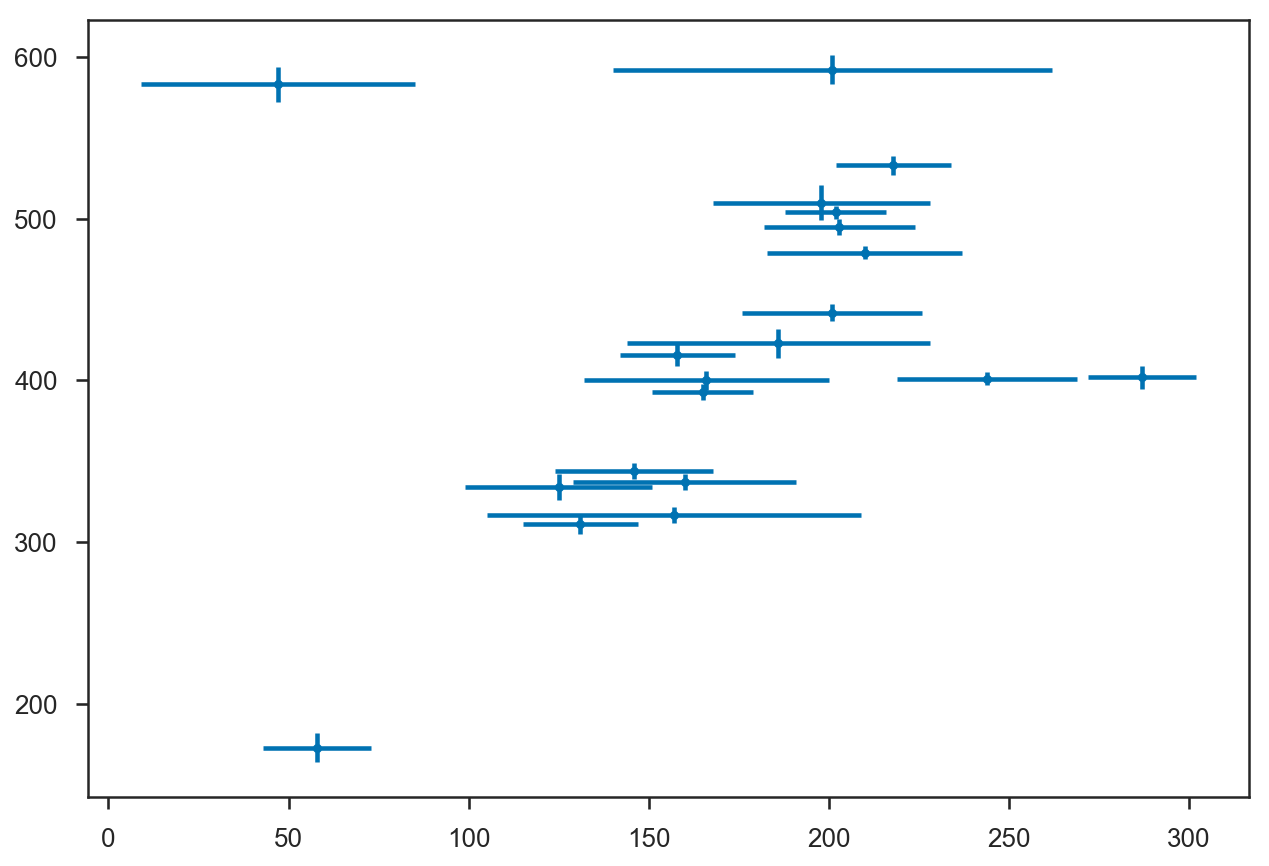

In [5]:
errorbar(table1['x'], table1['y'], xerr=table1['sigma_x'], yerr=table1['sigma_y'], fmt='.')

### Exercise 1

(I know that this can be computed analytically---and Hogg, et al. (2010) tell you how---but we're going to be computing anyway, so let's do it that way first.)

To do some fits, we will be using [Stan](http://mc-stan.org) (named, by the way for [Stanislaw Ulam](https://en.wikipedia.org/wiki/Stanislaw_Ulam)).  Stan is a specialised language for describing joint distributions of data and parameters.  Once the description is written down, Stan compiles the description to a C++ program that draws samples from the conditional distribution $p\left( \theta \mid d \right)$; a C++ compiler on your machine translates that into executable code, which we then drive from Python.  Whew.

For exercise 1, we assume that 
$$
y_\mathrm{true} = m x_\mathrm{true} + b
$$
and 
$$
y_\mathrm{obs} = y_\mathrm{true} + \sigma_y
$$

* Write stan program.

In [6]:
model = pystan.StanModel(file='linear_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_70a875d88505bb180d2df34c7eae85a1 NOW.


Exercise 1 asks us to fit all the data from the 5th to the 20th point, and ignore the uncertainty in $y$.

In [7]:
ex1N0 = 4

In [8]:
ex1_data = {'npts': table1['x'][ex1N0:].shape[0],
            'xs': table1['x'][ex1N0:],
            'ys': table1['y'][ex1N0:],
            'sigma_ys': table1['sigma_y'][ex1N0:]}

Inference for Stan model: anon_model_70a875d88505bb180d2df34c7eae85a1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m      2.33  1.5e-3   0.04   2.25    2.3   2.33   2.36   2.42    727    1.0
b       3.6    0.27   7.31 -11.15  -1.25    3.8   8.58   17.8    725    1.0
lp__ -202.3    0.03   0.99 -204.9 -202.7 -202.0 -201.6 -201.4   1301    1.0

Samples were drawn using NUTS at Mon Jul 10 15:12:20 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

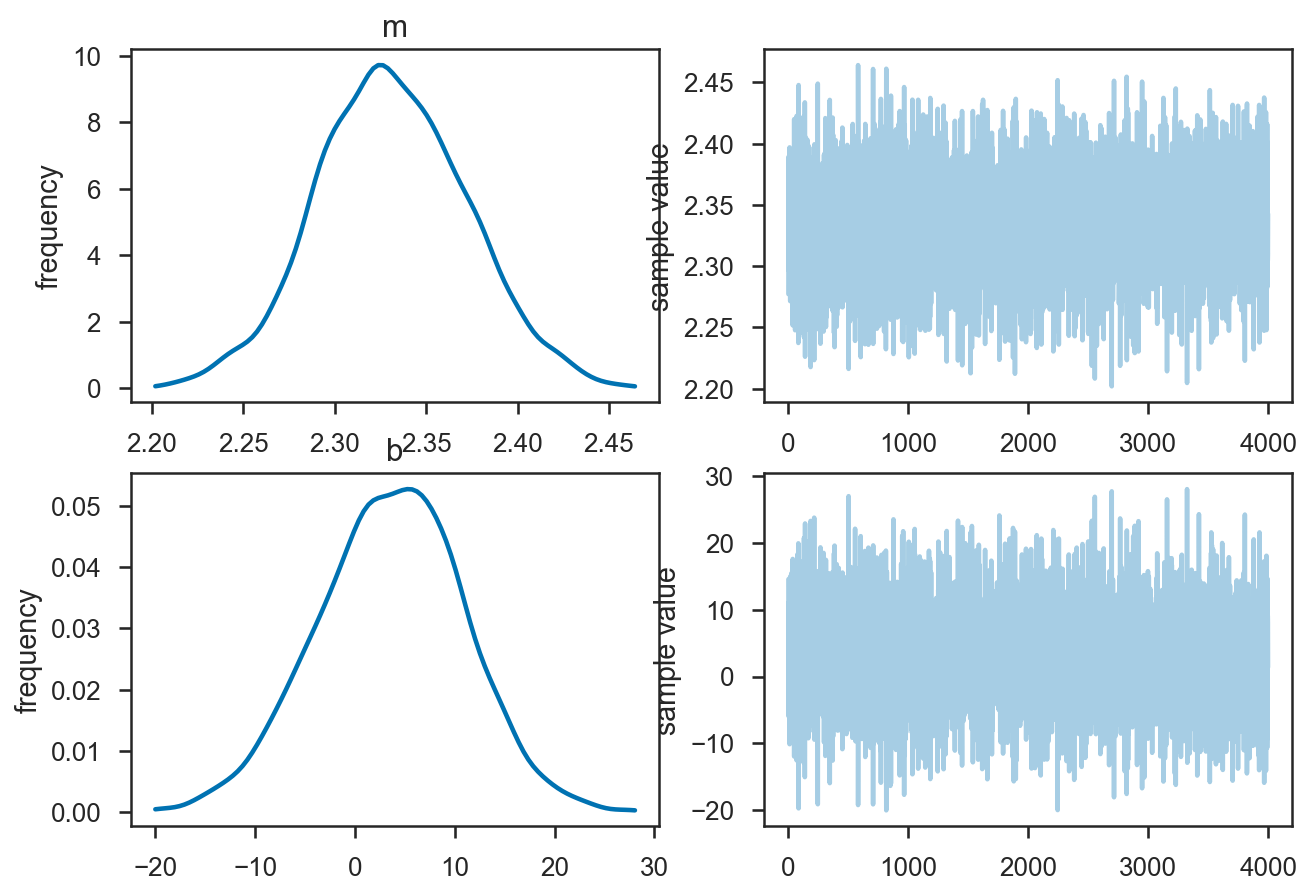

In [9]:
ex1_fit = model.sampling(data=ex1_data)
ex1_fit.plot()
ex1_fit

In [10]:
ex1_samples = ex1_fit.extract(permuted=True)

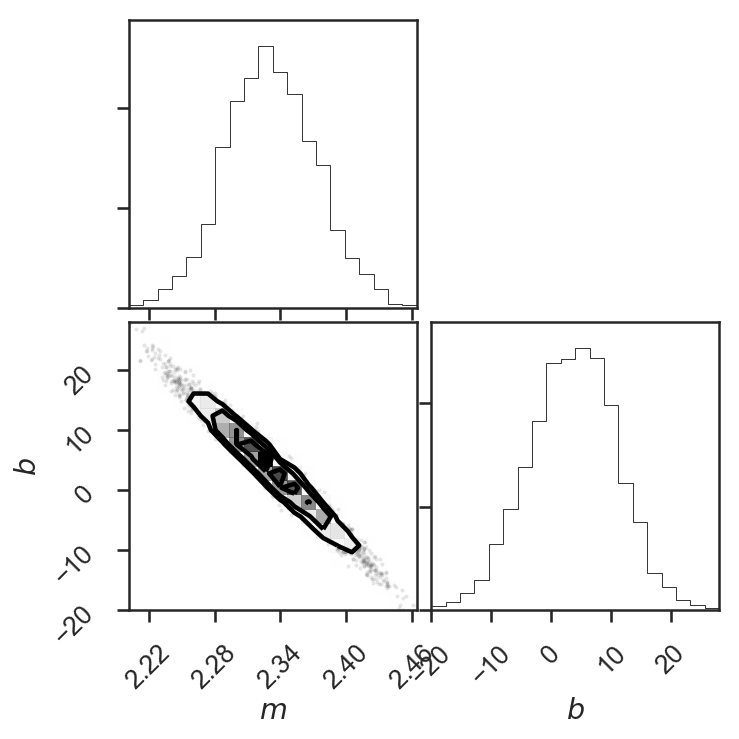

In [11]:
corner.corner(column_stack((ex1_samples['m'], ex1_samples['b'])), labels=[r'$m$', r'$b$']);

We *always* want to plot the output of our models in data space, to check whether the fit is good.  Let's define a function that does this:

In [12]:
def plot_errorbands(xs, ms, bs, *args, **kwargs):
    ys = []
    for m,b in zip(ms, bs):
        ys.append(m*xs + b)
    ys = array(ys)
    
    line, = plot(xs, median(ys, axis=0), *args, **kwargs)
    fill_between(xs, percentile(ys, 84, axis=0), percentile(ys, 16, axis=0), alpha=0.25, color=line.get_color())
    fill_between(xs, percentile(ys, 97.5, axis=0), percentile(ys, 16, axis=0), alpha=0.25, color=line.get_color())

A somewhat subtle point: our model has *implications* for $y_\mathrm{true}$.  $y_\mathrm{true} = m x + b$.  Thus we have a posterior on $y_\mathrm{true}$:

In [13]:
def plot_ytrues_no_scatter(xs, ms, bs, *args, **kwargs):
    ytrues = []
    for m,b in zip(ms, bs):
        ytrues.append(m*xs + b)
    ytrues = array(ytrues)
    
    errorbar(xs, mean(ytrues, axis=0), yerr=std(ytrues, axis=0), fmt='.', *args, **kwargs)

<Container object of 3 artists>

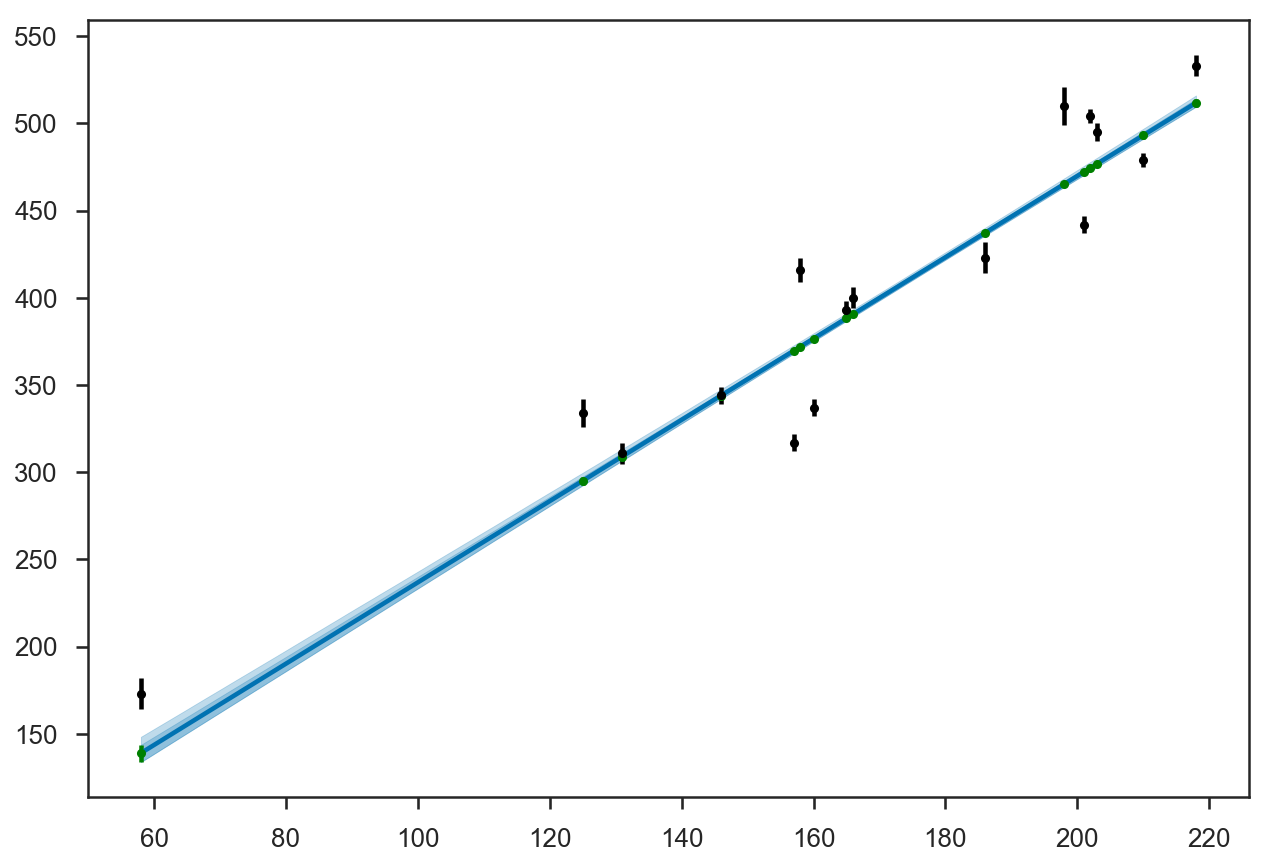

In [14]:
plot_errorbands(linspace(np.min(table1['x'][ex1N0:]), np.max(table1['x'][ex1N0:]), 1000), ex1_samples['m'], ex1_samples['b'])
plot_ytrues_no_scatter(table1['x'][ex1N0:], ex1_samples['m'], ex1_samples['b'], color='g')
errorbar(table1['x'][ex1N0:], table1['y'][ex1N0:], yerr=table1['sigma_y'][ex1N0:], fmt='.', color='k')

Places to go from here:
* Exercise 2: Fit the crappy data.
* Improve the model (it's obviously bad)?
* Better priors?
* Deal with outliers.

In [15]:
model_ilya = pystan.StanModel(file='linear_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ee1c29cd590d90290155d79cdc90968b NOW.


Inference for Stan model: anon_model_ee1c29cd590d90290155d79cdc90968b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m                    2.34  6.5e-3   0.23   1.88   2.19   2.34   2.48   2.78   1200    1.0
b                     2.3    1.16  40.46 -77.63 -23.88   1.46  28.45  84.02   1209    1.0
ilyas_idiot_factor   5.34    0.03   1.01   3.78   4.61   5.21    5.9   7.71   1106    1.0
lp__               -66.12    0.05   1.48 -70.12 -66.71 -65.75 -65.07 -64.47    875   1.01

Samples were drawn using NUTS at Mon Jul 10 15:24:54 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

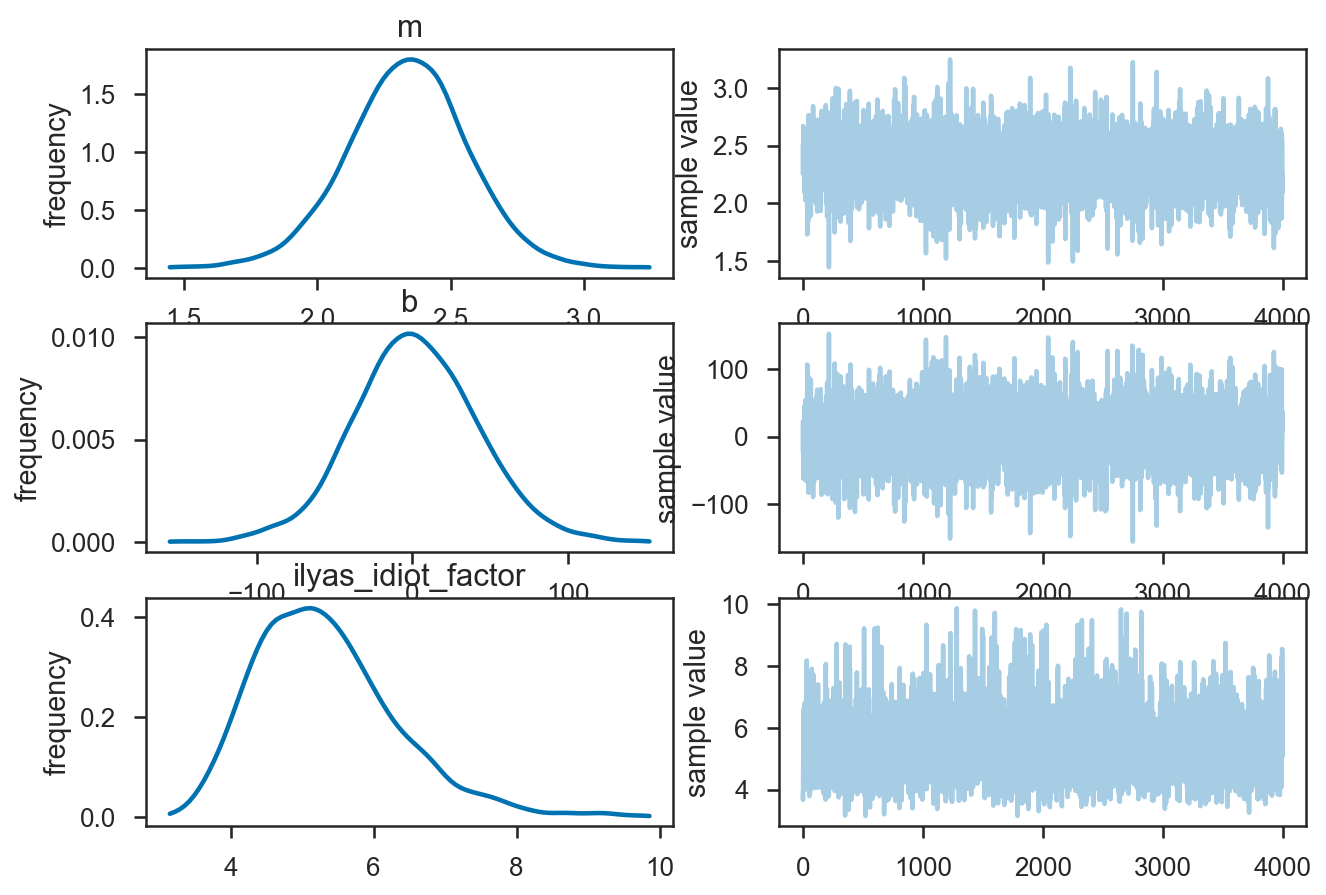

In [16]:
fit = model_ilya.sampling(data=ex1_data)
fit.plot()
fit

In [17]:
samples_ilya = fit.extract(permuted=True)

<Container object of 3 artists>

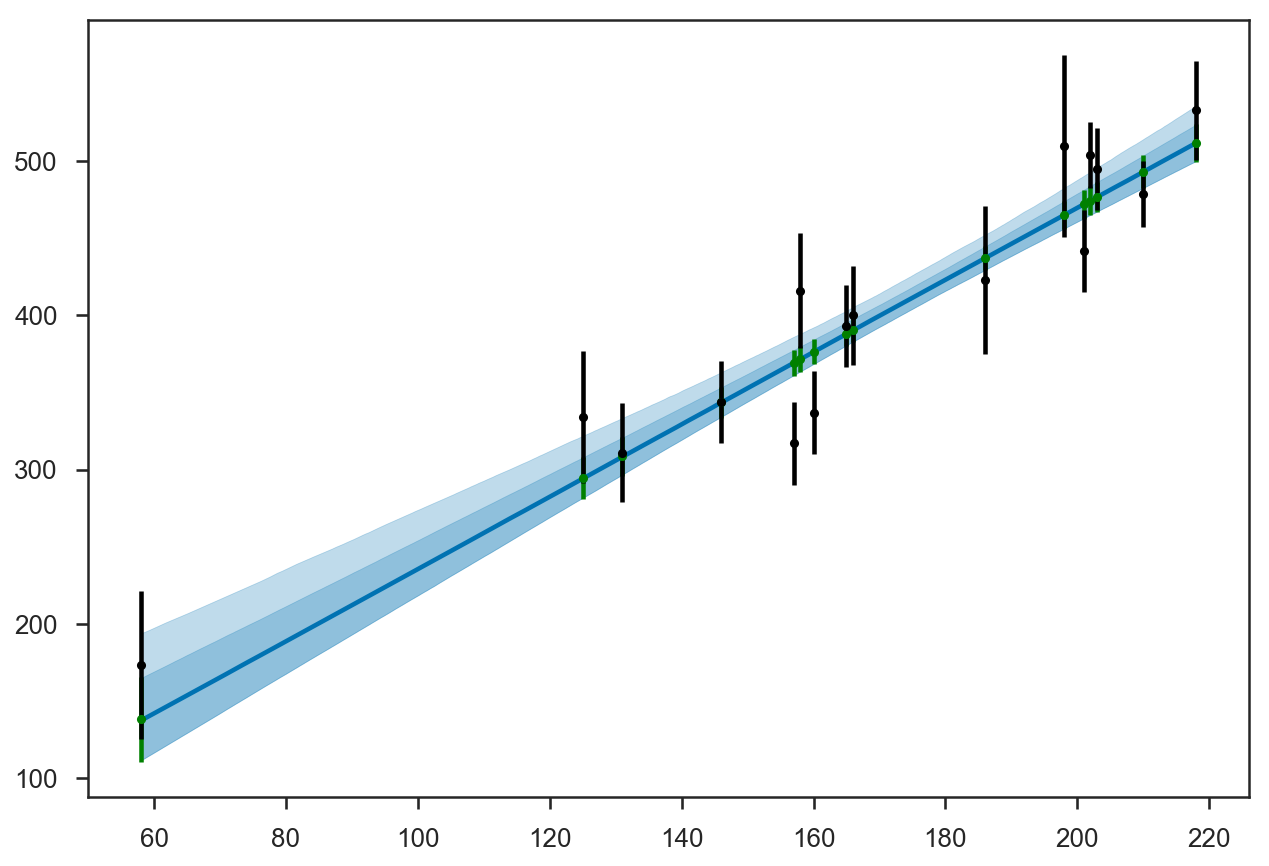

In [20]:
plot_errorbands(linspace(np.min(table1['x'][ex1N0:]), np.max(table1['x'][ex1N0:]), 1000), samples_ilya['m'], samples_ilya['b'])
plot_ytrues_no_scatter(table1['x'][ex1N0:], samples_ilya['m'], samples_ilya['b'], color='g')
errorbar(table1['x'][ex1N0:], table1['y'][ex1N0:], yerr=mean(samples_ilya['ilyas_idiot_factor'], axis=0)*table1['sigma_y'][ex1N0:], fmt='.', color='k')

In [21]:
model_scatter = pystan.StanModel(file='linear_model_scatter.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9ec8b6914580d488f7a11952c4631f56 NOW.


In [22]:
fit = model_scatter.sampling(data=ex1_data)

Inference for Stan model: anon_model_9ec8b6914580d488f7a11952c4631f56.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m            2.21  4.1e-3   0.22   1.78   2.07   2.22   2.36   2.65   2934    1.0
b           28.71    0.71  38.19 -44.67   3.58  28.49  52.75 103.96   2901    1.0
sigma       33.06    0.12   7.55  21.97  27.79  31.87  36.92  51.07   4000    1.0
y_true[0]   494.6    0.08   5.05 484.84 491.21 494.55 497.93 504.55   4000    1.0
y_true[1]  171.69    0.14   9.02 154.38 165.48 171.72 177.77 189.15   4000    1.0
y_true[2]  479.23    0.06   3.91 471.67  476.6 479.23 481.78 486.98   4000    1.0
y_true[3]  503.52    0.06   3.96 495.93 500.85 503.44 506.23 511.35   4000    1.0
y_true[4]  505.19    0.17  10.61 484.72 498.01 505.17 512.19 526.87   4000    1.0
y_true[5]  414.09    0.11   7.09 399.98 409.37 414.06 418.98 427.86   400

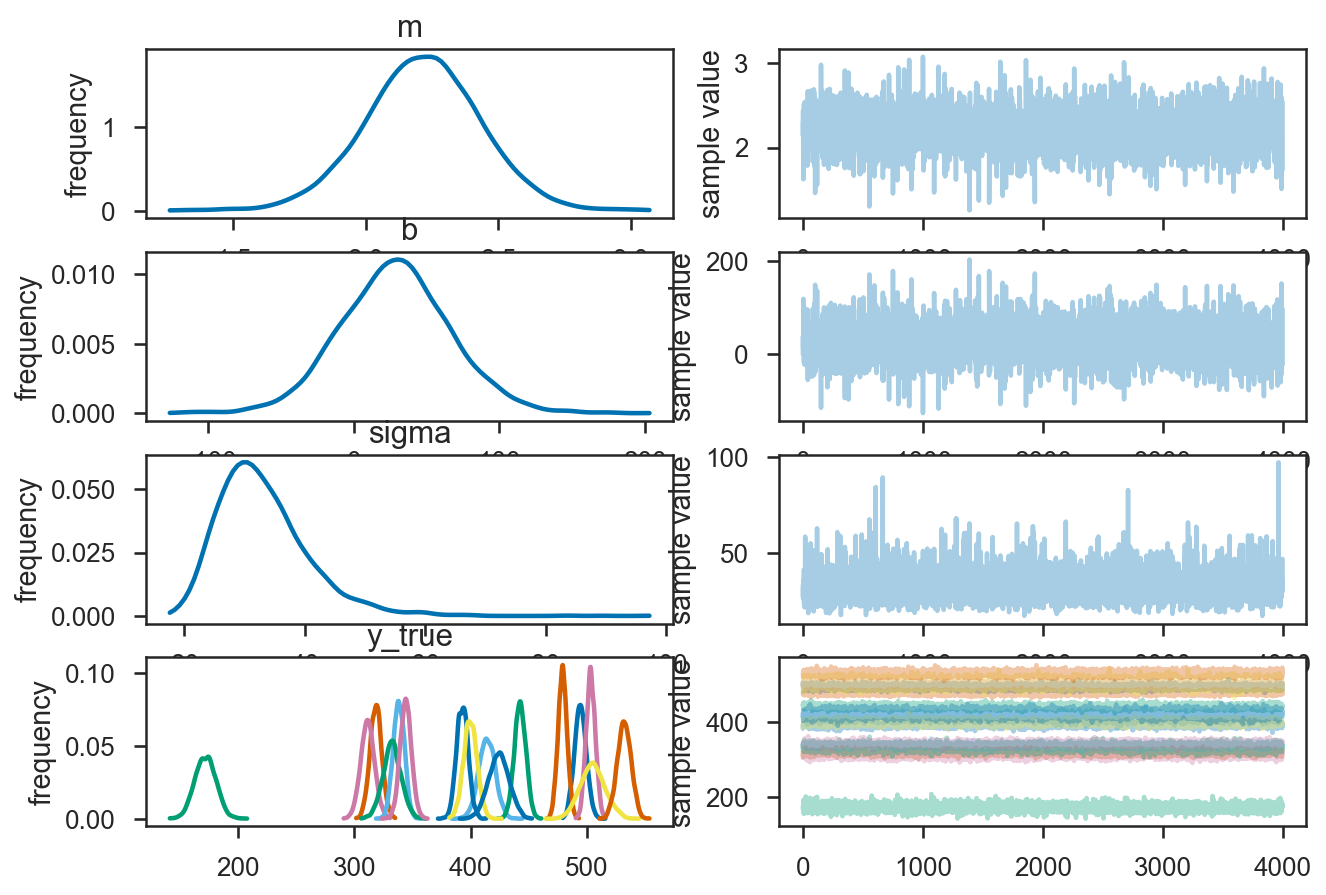

In [23]:
fit.plot()
fit

In [24]:
samples_scatter = fit.extract(permuted=True)

<Container object of 3 artists>

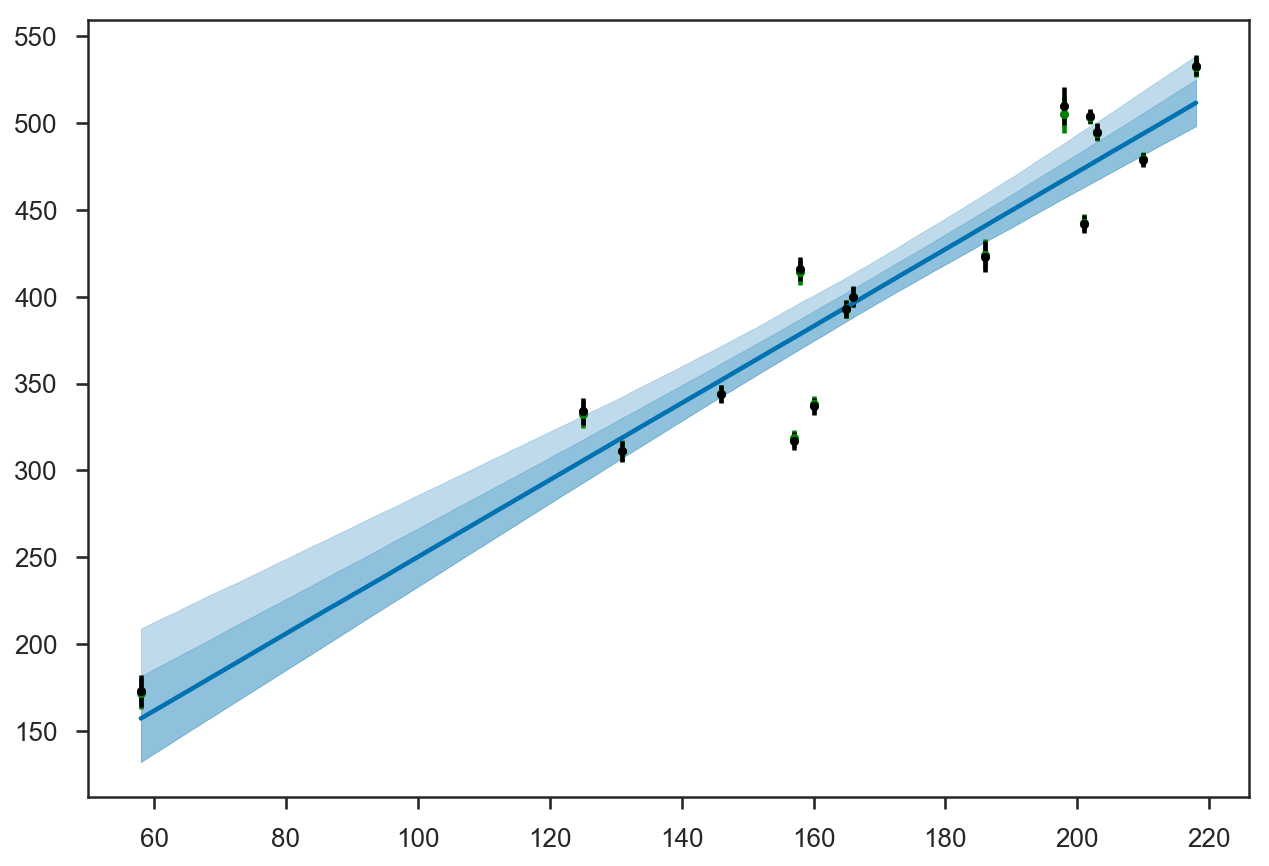

In [27]:
plot_errorbands(linspace(np.min(table1['x'][ex1N0:]), np.max(table1['x'][ex1N0:]), 1000), samples_scatter['m'], samples_scatter['b'])
errorbar(table1['x'][ex1N0:], mean(samples_scatter['y_true'], axis=0), yerr=std(samples_scatter['y_true'], axis=0), fmt='.', color='g')
errorbar(table1['x'][ex1N0:], table1['y'][ex1N0:], yerr=table1['sigma_y'][ex1N0:], fmt='.', color='k')

In [28]:
data_bad = {'npts': table1['x'].shape[0],
            'xs': table1['x'],
            'ys': table1['y'],
            'sigma_ys': table1['sigma_y']}

In [29]:
fit_bad = model_scatter.sampling(data=data_bad)

Inference for Stan model: anon_model_9ec8b6914580d488f7a11952c4631f56.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m            0.63  8.6e-3   0.45  -0.24   0.34   0.63   0.93   1.54   2739    1.0
b          309.23    1.55  81.81 145.82 255.81 308.78  364.0 467.51   2770    1.0
sigma      105.64    0.31  19.83  74.74  91.67 102.57 117.03 152.31   4000    1.0
y_true[0]  590.83    0.14    8.9 573.77 584.82 590.68 596.99 607.86   4000    1.0
y_true[1]  401.15    0.06    4.0  393.1 398.51 401.14 403.79 409.05   4000    1.0
y_true[2]  580.08    0.17  11.01  558.4 572.71  580.2 587.32 601.83   4000    1.0
y_true[3]  402.38    0.11   6.78 389.27 397.73  402.4 406.81 415.68   4000    1.0
y_true[4]  494.81    0.08   5.03 485.06 491.44 494.74  498.2  504.9   4000    1.0
y_true[5]  174.21    0.14   8.88  157.1 168.15 174.27  180.4 191.75   400

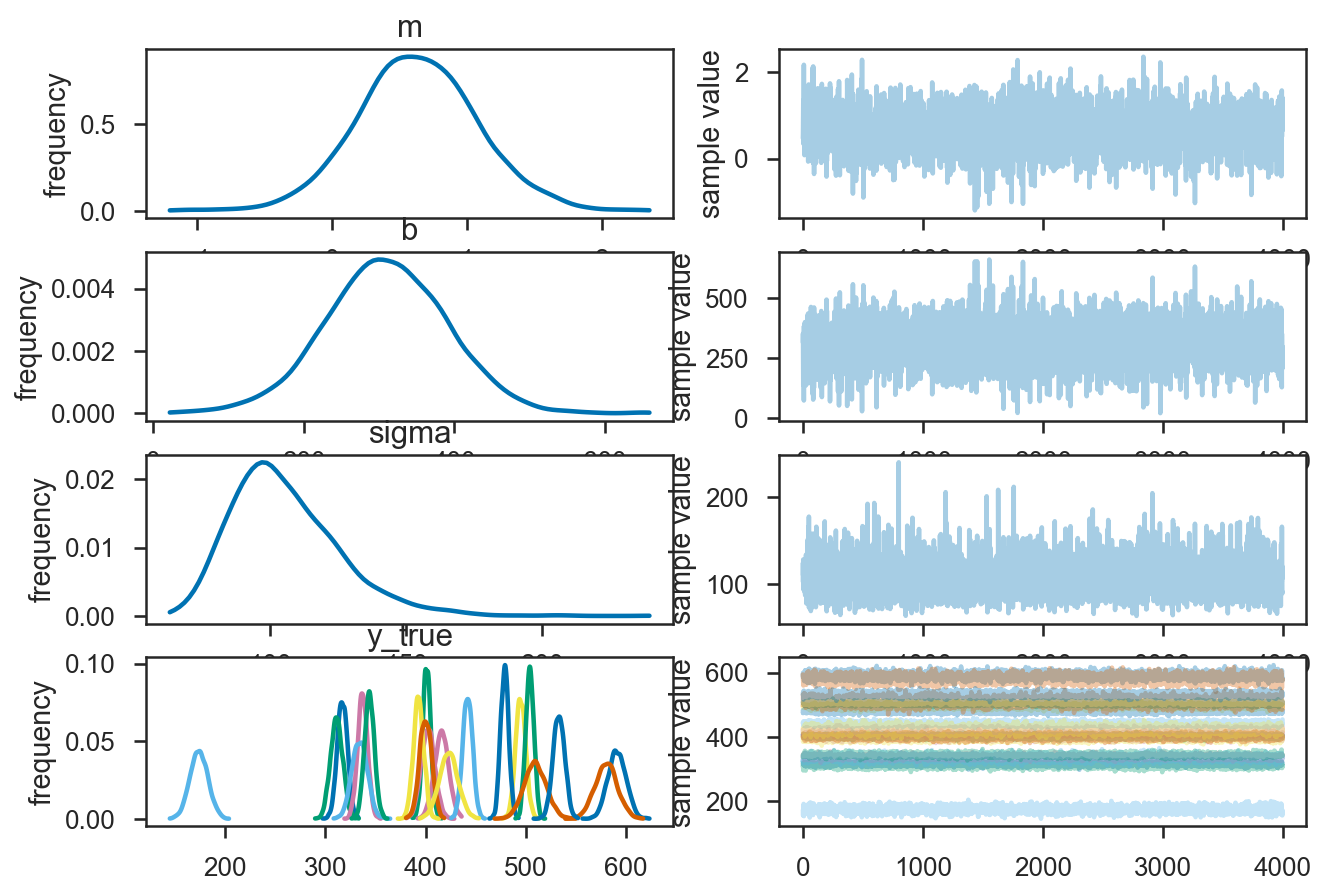

In [30]:
fit_bad.plot()
fit_bad

In [31]:
samples_bad = fit_bad.extract(permuted=True)

<Container object of 3 artists>

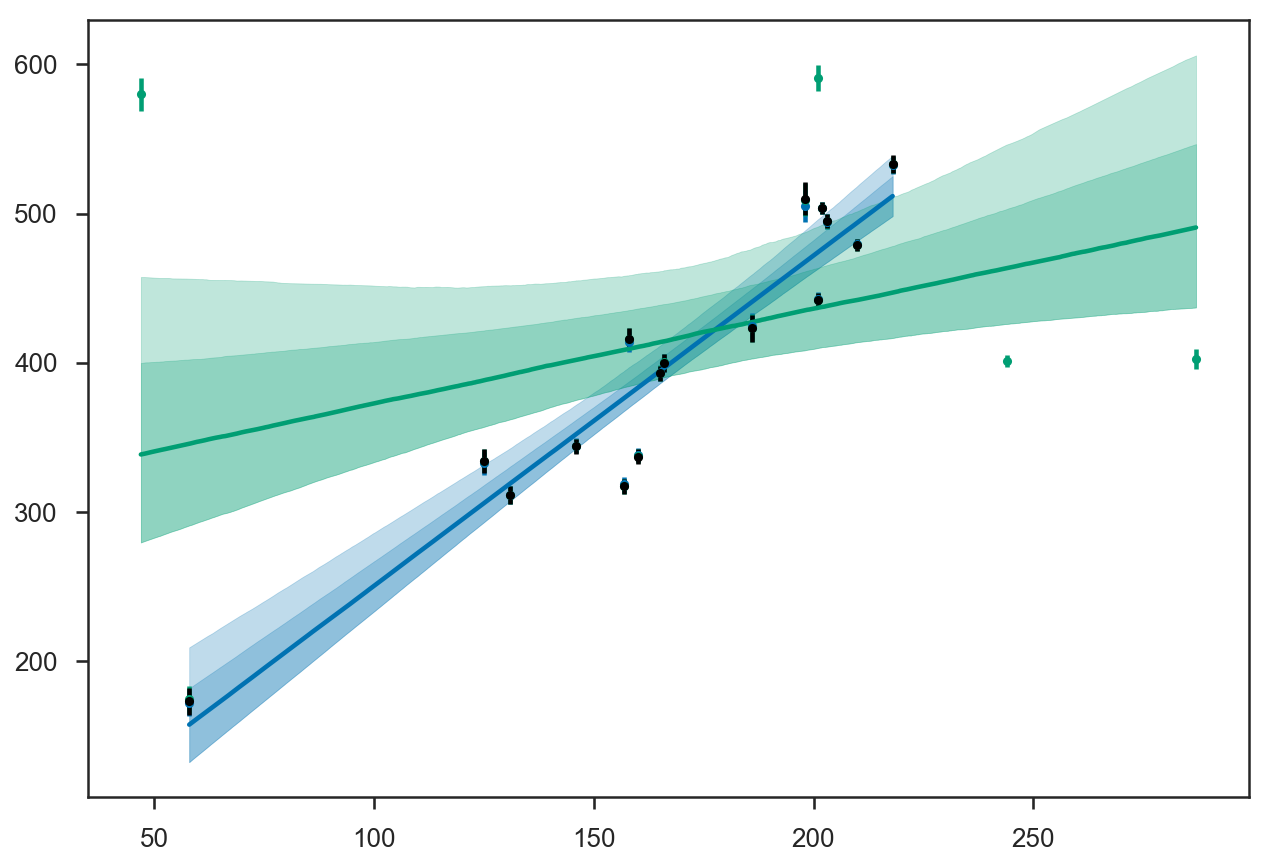

In [34]:
plot_errorbands(linspace(np.min(table1['x'][ex1N0:]), np.max(table1['x'][ex1N0:]), 1000), samples_scatter['m'], samples_scatter['b'])
plot_errorbands(linspace(np.min(table1['x']), np.max(table1['x']), 1000), samples_bad['m'], samples_bad['b'])
errorbar(table1['x'][ex1N0:], mean(samples_scatter['y_true'], axis=0), yerr=std(samples_scatter['y_true'], axis=0), fmt='.', color=sns.color_palette()[0])
errorbar(table1['x'], mean(samples_bad['y_true'], axis=0), yerr=std(samples_bad['y_true'], axis=0), fmt='.', color=sns.color_palette()[1])
errorbar(table1['x'][ex1N0:], table1['y'][ex1N0:], yerr=table1['sigma_y'][ex1N0:], fmt='.', color='k')

In [42]:
model_outilers = pystan.StanModel(file='linear_model_scatter_outlier.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1eeeacf94c2bac57d25d67f925bba74f NOW.


In [43]:
fit_outliers = model_outilers.sampling(data=data_bad)

In [44]:
fit_outliers

Inference for Stan model: anon_model_1eeeacf94c2bac57d25d67f925bba74f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m             8.5e13  9.6e13 1.4e14   1.83    2.2 5.2e12 1.1e14 4.8e14      2    2.3
b             5.9e12  1.1e13 3.6e13-9.0e13  -9.75  46.39 6.5e12 1.0e14     11    1.7
sigma          24.28    0.26  16.75   0.79  11.46  23.93   32.3  60.74   4000   1.04
y_true[0]     590.84    0.14   8.94 572.83 584.66 591.08 596.81 608.23   4000    1.0
y_true[1]      401.0    0.06    4.0 393.27 398.25 400.96 403.67 408.82   4000    1.0
y_true[2]     581.25    0.17  10.78 559.84 573.91 581.56  588.5 602.42   4000    1.0
y_true[3]     402.38    0.11   7.12 388.44 397.63 402.43 407.09 416.01   4000    1.0
y_true[4]     494.76    0.08   5.07 484.96 491.27 494.69 498.11 505.08   4000    1.0
y_true[5]     173.59    0.14   9.03 156.03 167